# Georgia LDU Closure Analysis (2012&ndash;2016)

In [1]:
from helper import *
show_dfs = False

## Datasets

### Patients

- Data from the *Emory MCH Linked Vital Records Data Repository* (private data source) is used to identify per-patient birth data for births in 2011 by birthing LDU, payor status, race, ethnicity, and county of residence.

In [2]:
# Load patient data.
patients = pd.read_csv('data/patients.csv')
show_df(patients, show_dfs)

### Labor & Delivery Units

- Data from *Georgia Maternal and Infant Health Research Group (GMIHRG)* (private data source) is used to identify the LDUs of interest and their birth counts in 2008, 2011, and 2012; numbers of OBs, FPs, and CNMs in 2011 and 2016; and average ages of OBs in 2011 and 2016.
- Data from the *Emory MCH Linked Vital Records Data Repository* (private data source) is used to obtain 2001 and 2011 number of births per-LDU to residents and non-residents of the county the LDU is in. It is also the source of LDU names that we consider standard.
- Data from the [*U.S. Census Bureau*](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html) is used to identify urban areas in 2010.
- Data from [*Google Maps*](https://www.google.com/maps/d/u/0/edit?mid=1_xMZrJgPbcInCcq8CgdmwuncWMWSOoJj&usp=sharing) is used to identify, for each LDU, the closest (other) LDU (within Georgia), the number of driving miles to the closest LDU, the closest urban area (in any state), and the number of driving miles to the closest urban area in 2011.

In [3]:
# Load LDU data.
ldus = pd.read_csv('data/ldus.csv')
show_df(ldus, show_dfs)

### Regional Data (Counties and PCSAs)

- Data from [*OASIS*](https://oasis.state.ga.us) is used to obtain birth and population counts in 2001 and 2011 by county.
- Data from the [*Office of Management and Budget (OMB)*](https://obamawhitehouse.archives.gov/sites/default/files/omb/bulletins/2013/b-13-01.pdf) is used to identify counties contained in the Atlanta-Sandy Springs-Roswell Metropolitan Statistical Area (MSA) based on the 2010 Census (see page 23).
- Data from the [*U.S. Census Bureau*](https://data.census.gov/cedsci/table?q=&t=Income%20and%20Poverty&g=0400000US13%240500000&y=2011&tid=ACSST5Y2011.S1903) is used to obtain 2011 median household income by county.
- Data from the [*Georgia Board of Health Care Workforce*](https://healthcareworkforce.georgia.gov/basic-physician-needs-reports-pcsa-primary-care-service-area) in the year 2008 is used to map counties to PCSAs.

In [4]:
# Load county data.
counties = pd.read_csv('data/counties.csv')
show_df(counties, show_dfs)

## Determining the Sample

### Inclusion Criteria for Rural PCSAs

PCSAs included in the sample are *rural*, meaning that in 2011:

1. They did not contain any counties that were within the Atlanta MSA.
2. They did not contain any counties with population at least 50,000.
3. They contained exactly one LDU.

In [5]:
# Construct a DataFrame of 96 PCSAs.
pcsas = pd.DataFrame({'PCSA' : [x+1 for x in range(96)]})

# Identify PCSAs that have no counties in the Atlanta MSA.
df = (counties.groupby('PCSA')['In MSA (2010)'].sum() == 0).to_frame('Inc. MSA')
df1 = pcsas.join(df, on='PCSA')

# Identify PCSAs whose counties all have population strictly less than 50K.
df = (counties.groupby('PCSA')['Population'].max() < 50000).to_frame('Inc. Pop')
df2 = pcsas.join(df, on='PCSA')

# Identify PCSAs containing exactly one LDU.
df = ldus.groupby('County').size().to_frame('# LDUs')
df = counties.join(df, on='County')
df = (df.groupby('PCSA')['# LDUs'].sum() == 1).to_frame('Inc. 1 LDU')
df3 = pcsas.join(df, on='PCSA')

# Determine which PCSAs are in sample.
pcsas['In Sample'] = df1['Inc. MSA'] & df2['Inc. Pop'] & df3['Inc. 1 LDU']

show_df(pcsas, show_dfs)

### Narrowing Patients, LDUs, and Counties to the Sample

With the 30 PCSAs in sample identified, the three other datasets can be winnowed down. All calculations from here on out can safely assume, due to Inclusion Criteria 3, that there is a 1:1 correspondence between LDUs and PCSAs.

In [6]:
# Collect the counties that are in sample.
df1 = counties.join(pcsas.set_index('PCSA'), on='PCSA')
s_counties = df1.drop(df1[df1['In Sample'].map(lambda x: not x)].index)
del s_counties['In Sample']

# Collect the LDUs that are in sample.
df2 = ldus.join(df1[['County', 'In Sample']].set_index('County'), on='County')
s_ldus = df2.drop(df2[df2['In Sample'].map(lambda x: not x)].index)
del s_ldus['In Sample']

# Collect the patients that are in sample.
df3 = patients.join(df2[['LDU', 'In Sample']].set_index('LDU'), on='LDU')
s_patients = df3.drop(df3[df3['In Sample'].map(lambda x: not x)].index)
del s_patients['In Sample']

# Finally, collect the PCSAs that are in sample.
s_pcsas = pcsas.drop(pcsas[pcsas['In Sample'].map(lambda x: not x)].index)
del s_pcsas['In Sample']

## Derived Columns

Based on the raw data above, we derive a series of new columns at the patient, LDU, and PCSA levels.

### Patient Payor Types/Groups and Residence

We aggregate different payor statuses into types and groups according to the dictionaries below. We also identify which patients gave birth to an LDU within their county and PCSA of residence.

In [7]:
# Assign patients their payor types.
ptypes = {'Unknown': 'Other/Unknown',
          'Champus': 'Commercial/Employer-Based',
          'Medicaid': 'Medicaid',
          'Commercial Insurance': 'Commercial/Employer-Based',
          'Other Government Assistance': 'Other Govt.',
          'Other': 'Other/Unknown',
          'Self Pay': 'Self Pay'}
s_patients['Payor Type'] = s_patients['Payor'].map(lambda x: ptypes[x])

# Assign patients their payor groups.
pgroups = {'Commercial/Employer-Based': 'Commercial/Employer-Based',
           'Medicaid': 'Assistance/Self Pay',
           'Other Govt.': 'Assistance/Self Pay',
           'Self Pay': 'Assistance/Self Pay',
           'Other/Unknown': 'Other/Unknown'}
s_patients['Payor Group'] = s_patients['Payor Type'].map(lambda x: pgroups[x])

# Use the counties of each LDU to identify whether patients gave birth in their
# county of residence.
df1 = s_patients.join(ldus[['LDU', 'County']].set_index('LDU'), on='LDU')
s_patients['In Res. County'] = s_patients['Res. County'] == df1['County']

# Use the counties of each LDU and the mappings of counties to PCSAs to identify
# whether patients gave birth in their PCSA of residence.
df2 = s_patients.join(counties[['County', 'PCSA']].set_index('County'), \
                      on='Res. County')
df3 = df1.join(counties[['County', 'PCSA']].set_index('County'), on='County')
s_patients['In Res. PCSA'] = df2['PCSA'] == df3['PCSA']

show_df(s_patients, show_dfs)

### Patient Demographics, Payor Types/Groups, and Resident Births by LDU

Using the 2011 patient-level data in the above table, we aggregate the following measures by LDU:
- Number of patients by race (Black, white, and other)
- Number of patients by payor type (commercial/employer-based, Medicaid, self pay, other government, and other/unknown)
- Number of patients by payor group (commercial/employer-based and assistance/self pay)
- Number of patients in each pairwise intersection of Black vs. white and commercial/employer-based vs. assistance/self pay
- Number of births to residents and non-residents of the LDU's county and PCSA

In [8]:
# Count total number of patients per LDU.
df1 = s_patients.groupby('LDU').size().to_frame('# Patients')
s_ldus = s_ldus.join(df1, on='LDU')

# Count patients by race per LDU.
df1 = s_patients.groupby(['LDU', 'Race']).size().to_frame('#').reset_index()
for race in ['Black or African-American', 'White']:
    df2 = df1[df1['Race'] == race]
    df2 = s_ldus.join(df2[['LDU', '#']].set_index('LDU'), on='LDU')
    s_ldus[race.split()[0] + ' Patients'] = df2['#']
s_ldus['Other/Unknown Race'] = s_ldus['# Patients'] - s_ldus['Black Patients'] \
                               - s_ldus['White Patients']

# Count patients by payor type per LDU.
df1 = s_patients.groupby(['LDU', 'Payor Type']).size().to_frame('#').reset_index()
for ptype in ['Commercial/Employer-Based', 'Medicaid', 'Self Pay', \
              'Other Govt.', 'Other/Unknown']:
    df2 = df1[df1['Payor Type'] == ptype]
    df2 = s_ldus.join(df2[['LDU', '#']].set_index('LDU'), on='LDU')
    s_ldus[ptype + ' Payors'] = df2['#'].fillna(0)

# Count patients by payor group per LDU.
df1 = s_patients.groupby(['LDU', 'Payor Group']).size().to_frame('#').reset_index()
for pgroup in ['Commercial/Employer-Based', 'Assistance/Self Pay']:
    df2 = df1[df1['Payor Group'] == pgroup]
    df2 = s_ldus.join(df2[['LDU', '#']].set_index('LDU'), on='LDU')
    s_ldus[pgroup + ' Payors'] = df2['#'].fillna(0)
    
# Count patients by intersection of race and payor groups.
df1 = s_patients.groupby(['LDU', 'Race', 'Payor Group']).size()\
                .to_frame('#').reset_index()
for race, pgroup in product(['Black or African-American', 'White'], \
                            ['Commercial/Employer-Based', 'Assistance/Self Pay']):
    df2 = df1[(df1['Race'] == race) & (df1['Payor Group'] == pgroup)]
    df2 = s_ldus.join(df2[['LDU', '#']].set_index('LDU'), on='LDU')
    s_ldus[race.split()[0] + ' ' + pgroup] = df2['#'].fillna(0)

# Count births to county and PCSA residents.
for area in ['County', 'PCSA']:
    res_str = area + ' Res. Patients'
    nonres_str = area + ' Non-Res. Patients'
    df1 = s_patients.groupby(['LDU', 'In Res. ' + area]).size()\
                    .to_frame(res_str).reset_index()
    df2 = df1[df1['In Res. ' + area]]
    s_ldus = s_ldus.join(df2[['LDU', res_str]].set_index('LDU'), on='LDU')
    s_ldus[nonres_str] = s_ldus['# Patients'] - s_ldus[res_str]

show_df(s_ldus, show_dfs)

### Provider Count and Load by LDU

We count providers by the number of OB equivalents per LDU in 2011 and use it to calculate the number of births per provider. An OB equivalent is calculated as:
$$
(\#OBs) + \frac{1}{1.55} \cdot (\#CNMs) + \frac{0.7}{1.55} \cdot (\#FPs)
$$

We also identify the birth volume of the closest LDU.

In [9]:
# Calculate OB equivalents and births per provider.
s_ldus['OB Equiv.'] = s_ldus['# OBs'] + s_ldus['# CNMs'] / 1.55 \
                      + (0.7/1.55) * s_ldus['# FPs']
s_ldus['Births per Provider'] = s_ldus['# Births'] / s_ldus['OB Equiv.']

# Get the 2011 birth volume at the closest LDU.
s_ldus = s_ldus.join(ldus[['LDU', '# Births']].set_index('LDU'), \
                     on='Closest GA LDU', rsuffix=' at Closest GA LDU')

show_df(s_ldus, show_dfs)

### County Birth Volume and Population Demographics by PCSA

We additionally calculate, per-PCSA: the birth volume (2011), population (2011), female population (2011), Black female population (2011), white female population (2011), other female population (2011), and household income (2011). Median household income is available on a per-county basis; to calculate a PCSA's household income, we take a weighted average of its counties' median household incomes weighted by each county's proportion of the PCSA population. Mathematically, for a PCSA $p$ containing counties $c_1, \ldots, c_k$ we have:
$$
\text{income}(p) = \sum_{i=1}^k \left(\frac{\text{population}(c_i)}{\text{population}(p)}\right) \cdot \text{income}(c_i) = \frac{1}{\text{population}(p)} \cdot \sum_{i=1}^k \text{population}(c_i) \cdot \text{income}(c_i)
$$

In [10]:
# Calculate the birth volume per-PCSA in 2011, the total population per-PCSA in
# 2011, and the female populations per-PCSA in 2011.
for m in ['# Births', 'Population', 'Females 15-44']:
    s_pcsas = s_pcsas.join(s_counties.groupby('PCSA')[m].sum().to_frame(m), \
                           on='PCSA')
    
# Calculate populations of Black, white, and other race females by PCSA.
for m in ['Black Females 15-44', 'White Females 15-44']:
    df = s_counties.groupby('PCSA')[m].sum().to_frame('#')
    df = s_pcsas.join(df, on='PCSA')
    s_pcsas[m] = df['#']
s_pcsas['Other Females 15-44'] = s_pcsas['Females 15-44'] \
                                 - s_pcsas['Black Females 15-44'] \
                                 - s_pcsas['White Females 15-44']
    
# Calculate the median household income per-PCSA using population-weighted
# proportions by county.
df = s_counties.groupby('PCSA')\
               .apply(lambda x: (x['Population']*x['Median Household Income'])\
               .sum()).to_frame('incprod')
df = s_pcsas.join(df, on='PCSA')
s_pcsas['Household Income'] = df['incprod'] / df['Population']

Finally, we identify which PCSAs had LDUs that closed (recall the assumption of 1:1 LDU:PCSA correspondence by Inclusion Criterium 3).

In [11]:
close_str = 'Closed 2012-2016'
df = s_ldus.groupby('County')[close_str].sum().to_frame(close_str)
df = s_counties[['County', 'PCSA']].join(df, on='County').fillna(0)
df = df.groupby('PCSA')[close_str].sum().to_frame(close_str)
s_pcsas = s_pcsas.join(df, on='PCSA')

show_df(s_pcsas, show_dfs)

### Dumping the Processed Data

We write the processed patient, LDU, county, and PCSA data to file for easier inspection.

In [12]:
s_pcsas.to_csv('data/processed_pcsas.csv')
s_counties.to_csv('data/processed_counties.csv')
s_ldus.to_csv('data/processed_ldus.csv')
s_patients.to_csv('data/processed_patients.csv')

## Analysis

There are two classes of measures $m$ that we report statistics on.

1. *Counts* (e.g., the number of births in a given year, household incomes, or populations), for which we report the total $\sum_{p \in P} m(p)$ and, for each subset of $P^{open}, P^{closed} \subseteq P$, the:
    - Median: $median(\{m(p) : p \in P^{open/closed}\})$
    - Min: $min(\{m(p) : p \in P^{open/closed}\})$
    - Max: $max(\{m(p) : p \in P^{open/closed}\})$
    - p-value of a [Mann-Whitney U rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu) on $\{m(p) : p \in P^{open}\}$ vs. $\{m(p) : p \in P^{closed}\}$
2. *Proportions* (e.g., the percentage of the female population in a given PCSA that is Black), for which we report the same statistics as for Counts (but the total remains the raw total, not the sum of the proportions).

### Odds Ratios

An odds ratio for Black and white populations by PCSA is investigated against LDU closure status.

In [13]:
two_by_two(s_pcsas, 'Black Females 15-44', 'White Females 15-44')

Black Females 15-44, Closed:  8,494.00
White Females 15-44, Closed:  17,795.00
Black Females 15-44, Open:    45,326.00
White Females 15-44, Open:    101,442.00


Using the [OpenEpi](https://openepi.com/TwobyTwo/TwobyTwo.htm) calculator, we obtain an odds ratio of $1.068 \in [1.039, 1.099]$.

An odds ratio for Black and white patients with known payor groups is investigated against LDU closure status.

In [14]:
# Create a temporary DataFrame combining known payor groups.
df = s_ldus['Closed 2012-2016'].to_frame()
df['Black Known Payor Group'] = s_ldus['Black Commercial/Employer-Based'] \
                                + s_ldus['Black Assistance/Self Pay']
df['White Known Payor Group'] = s_ldus['White Commercial/Employer-Based'] \
                                + s_ldus['White Assistance/Self Pay']
two_by_two(df, 'Black Known Payor Group', 'White Known Payor Group')

Black Known Payor Group, Closed:  399.00
White Known Payor Group, Closed:  444.00
Black Known Payor Group, Open:    3,214.00
White Known Payor Group, Open:    5,212.00


Using the [OpenEpi](https://openepi.com/TwobyTwo/TwobyTwo.htm) calculator, we obtain an odds ratio of $1.457 \in [1.264, 1.680]$.

To check if payor group is confounding, we further partition these black and white patients counts by payor groups "Assistance/Self Pay" and "Commercial/Employer-Based".

In [15]:
for pgroup in ['Assistance/Self Pay', 'Commercial/Employer-Based']:
    two_by_two(s_ldus, 'Black '+pgroup, 'White '+pgroup)
    print()

Black Assistance/Self Pay, Closed:  378.00
White Assistance/Self Pay, Closed:  372.00
Black Assistance/Self Pay, Open:    2,982.00
White Assistance/Self Pay, Open:    3,876.00

Black Commercial/Employer-Based, Closed:  21.00
White Commercial/Employer-Based, Closed:  72.00
Black Commercial/Employer-Based, Open:    232.00
White Commercial/Employer-Based, Open:    1,336.00



Using the [OpenEpi](https://openepi.com/TwobyTwo/TwobyTwo.htm) calculator on these strata, we obtain a Cochran-Mantel-Haenszel adjusted odds ratio of $1.344 \in [1.163, 1.553]$.

An odds ratio for Assistance/Self Pay and Commercial/Employer-Based patient payor groups is investigated against LDU closure status.

In [16]:
two_by_two(s_ldus, 'Assistance/Self Pay Payors', 'Commercial/Employer-Based Payors')

Assistance/Self Pay Payors, Closed:        827.00
Commercial/Employer-Based Payors, Closed:  97.00
Assistance/Self Pay Payors, Open:          8,062.00
Commercial/Employer-Based Payors, Open:    1,654.00


Using the [OpenEpi](https://openepi.com/TwobyTwo/TwobyTwo.htm) calculator, we obtain an odds ratio of $1.749 \in [1.408, 2.173]$.

An odds ratio for PCSA resident patients vs. PCSA non-resident patients is investigated against LDU closure status.

In [17]:
two_by_two(s_ldus, 'PCSA Res. Patients', 'PCSA Non-Res. Patients')

PCSA Res. Patients, Closed:      753.00
PCSA Non-Res. Patients, Closed:  370.00
PCSA Res. Patients, Open:        6,511.00
PCSA Non-Res. Patients, Open:    4,658.00


Using the [OpenEpi](https://openepi.com/TwobyTwo/TwobyTwo.htm) calculator, we obtain an odds ratio of $1.456 \in [1.278, 1.658]$.

### Table 1: Race and Payor Group by LDU Closure Status (2011)

#### PCSA Data

Each PCSA's 2011 total population ("Population"), 2011 female population ("Females 15-44"), and 2011 household income ("Household Income") are investigated as Counts.

Each PCSA's 2011 Black female population ("Black Females 15-44"), white female population ("White Females 15-44"), and other race female population ("Other Females 15-44") are investigated as Proportions.

In [18]:
# Count measure statistics.
for m in ['Population', 'Females 15-44', 'Household Income']:
    count_stats(s_pcsas, m)
    print()
    
# Proportion measure statistics.
for m in ['Black Females 15-44', 'White Females 15-44', 'Other Females 15-44']:
    proportion_stats(s_pcsas, m, 'Females 15-44')
    print()

Population
----------
Total:      935,890.000
Open:       median=26,827.000  (9,679.000 - 61,530.000)
Closed:     median=23,035.500  (17,125.000 - 31,086.000)
Mann-Whit:  pval=0.250633658

Females 15-44
-------------
Total:      178,044.000
Open:       median=5,053.500   (1,646.000 - 12,226.000)
Closed:     median=4,397.500   (3,281.000 - 6,405.000)
Mann-Whit:  pval=0.296230053

Household Income
----------------
Total:      1,049,522.682
Open:       median=34,248.881  (31,123.253 - 43,146.000)
Closed:     median=33,588.500  (30,427.000 - 43,704.000)
Mann-Whit:  pval=0.630949434

% Black Females 15-44
---------------------
Total:      53,820.000
Open:       median=30.163%     (0.884% - 53.831%)
Closed:     median=34.450%     (1.530% - 54.653%)
Mann-Whit:  pval=0.595269252

% White Females 15-44
---------------------
Total:      119,237.000
Open:       median=67.419%     (42.783% - 97.054%)
Closed:     median=63.439%     (43.491% - 95.706%)
Mann-Whit:  pval=0.667427898

% Other Females 1

#### Patient Race by LDU

Each LDU's Black patients ("Black Patients"), white patients ("White Patients"), and other race patients ("Other/Unknown Race") are investigated as Proportions.

In [19]:
for m in ['Black Patients', 'White Patients', 'Other/Unknown Race']:
    proportion_stats(s_ldus, m, '# Patients')
    print()

% Black Patients
----------------
Total:      4,101.000
Open:       median=31.851%     (0.392% - 66.667%)
Closed:     median=41.918%     (1.463% - 72.487%)
Mann-Whit:  pval=0.402128752

% White Patients
----------------
Total:      6,713.000
Open:       median=56.038%     (22.180% - 94.828%)
Closed:     median=40.285%     (25.397% - 95.122%)
Mann-Whit:  pval=0.493941308

% Other/Unknown Race
--------------------
Total:      1,478.000
Open:       median=9.444%      (3.072% - 45.113%)
Closed:     median=3.844%      (2.116% - 27.193%)
Mann-Whit:  pval=0.173998568



#### Patient Insurance by LDU

Each LDU's breakdown of patients by payor type ("Commercial/Employer-Based", "Medicaid", "Self Pay", "Other Govt.", and "Other/Unknown") are investigated as Proportions.

In [20]:
for ptype in ['Commercial/Employer-Based', 'Medicaid', 'Self Pay', \
              'Other Govt.', 'Other/Unknown']:
    proportion_stats(s_ldus, ptype+' Payors', '# Patients')
    print()

% Commercial/Employer-Based Payors
----------------------------------
Total:      1,751.000
Open:       median=10.798%     (0.196% - 30.508%)
Closed:     median=5.264%      (3.285% - 25.366%)
Mann-Whit:  pval=0.157773567

% Medicaid Payors
-----------------
Total:      7,390.000
Open:       median=71.435%     (5.501% - 91.892%)
Closed:     median=62.939%     (29.268% - 94.545%)
Mann-Whit:  pval=0.781194897

% Self Pay Payors
-----------------
Total:      921.000
Open:       median=4.447%      (0.000% - 39.850%)
Closed:     median=4.343%      (0.000% - 26.496%)
Mann-Whit:  pval=0.979852638

% Other Govt. Payors
--------------------
Total:      578.000
Open:       median=0.343%      (0.000% - 62.069%)
Closed:     median=0.427%      (0.000% - 2.555%)
Mann-Whit:  pval=0.781194897

% Other/Unknown Payors
----------------------
Total:      1,652.000
Open:       median=1.375%      (0.000% - 86.531%)
Closed:     median=11.419%     (0.000% - 43.415%)
Mann-Whit:  pval=0.526704560



### Table 2: Birth Volume and Location by LDU Closure Status (2011)

The number of births by PCSA ("# Births) is investigated as a Count measure.

In [21]:
count_stats(s_pcsas, '# Births')

# Births
--------
Total:      11,976.000
Open:       median=365.000     (101.000 - 776.000)
Closed:     median=313.000     (213.000 - 361.000)
Mann-Whit:  pval=0.493941308


Each LDU's 2011 birth volume ("# Births") is investigated as a Count measure.

In [22]:
count_stats(s_ldus, '# Births')

# Births
--------
Total:      12,452.000
Open:       median=435.500     (111.000 - 1,105.000)
Closed:     median=197.000     (110.000 - 274.000)
Mann-Whit:  pval=0.002684519


Each LDU's 2011 birth volume at the nearest Georgia LDU ("# Births at Closest GA LDU"), distance to nearest Georgia LDU ("Miles to Closest GA LDU"), and distance to nearest urban area ("Miles to Closest Urban Area") are investigated as Counts.

In [23]:
for m in ['# Births at Closest GA LDU', 'Miles to Closest GA LDU', \
          'Miles to Closest Urban Area']:
    count_stats(s_ldus, m)
    print()

# Births at Closest GA LDU
--------------------------
Total:      18,519.000
Open:       median=327.000     (110.000 - 2,569.000)
Closed:     median=773.500     (118.000 - 3,454.000)
Mann-Whit:  pval=0.064681066

Miles to Closest GA LDU
-----------------------
Total:      700.000
Open:       median=24.500      (7.000 - 34.000)
Closed:     median=25.000      (19.000 - 32.000)
Mann-Whit:  pval=0.595269252

Miles to Closest Urban Area
---------------------------
Total:      1,314.000
Open:       median=41.500      (26.000 - 64.000)
Closed:     median=41.500      (21.000 - 69.000)
Mann-Whit:  pval=0.742624732



Each LDU's 2011 number of births to county residents ("County Res. Patients") is investigated as a Proportion.

In [24]:
proportion_stats(s_ldus, 'County Res. Patients', '# Patients')

% County Res. Patients
----------------------
Total:      6,710.000
Open:       median=55.198%     (6.518% - 89.723%)
Closed:     median=66.140%     (48.718% - 88.182%)
Mann-Whit:  pval=0.092526630


### Table 3: Obstetric Providers by LDU Closure Status

Each LDU's providers expressed as the number of OBs ("# OBs"), CNMs ("# CNMs"), FPs ("# FPs"), and OB eqivalents ("OB Equiv.") as well as the average annual birth volume per provider ("Births per Provider") and average OB age ("Ave. OB Age") are investigated as Counts.

In [25]:
for m in ['# OBs', '# CNMs', '# FPs', 'OB Equiv.', 'Births per Provider', \
          'Ave. OB Age']:
    count_stats(s_ldus, m)
    print()

# OBs
-----
Total:      79.000
Open:       median=3.000       (0.000 - 6.000)
Closed:     median=1.500       (1.000 - 2.000)
Mann-Whit:  pval=0.043787630

# CNMs
------
Total:      15.000
Open:       median=0.000       (0.000 - 4.000)
Closed:     median=0.000       (0.000 - 1.000)
Mann-Whit:  pval=0.939655593

# FPs
-----
Total:      11.000
Open:       median=0.000       (0.000 - 4.000)
Closed:     median=0.000       (0.000 - 2.000)
Mann-Whit:  pval=0.526704560

OB Equiv.
---------
Total:      93.645
Open:       median=3.000       (1.000 - 7.935)
Closed:     median=2.000       (1.645 - 2.097)
Mann-Whit:  pval=0.043787630

Births per Provider
-------------------
Total:      3,974.626
Open:       median=133.638     (55.500 - 233.000)
Closed:     median=108.250     (55.000 - 143.966)
Mann-Whit:  pval=0.033120290

Ave. OB Age
-----------
Total:      1,252.800
Open:       median=46.000      (40.000 - 59.500)
Closed:     median=48.000      (45.000 - 60.000)
Mann-Whit:  pval=0.308300395



### Figure 1: Median Proportions of Black Women per PCSA and LDU

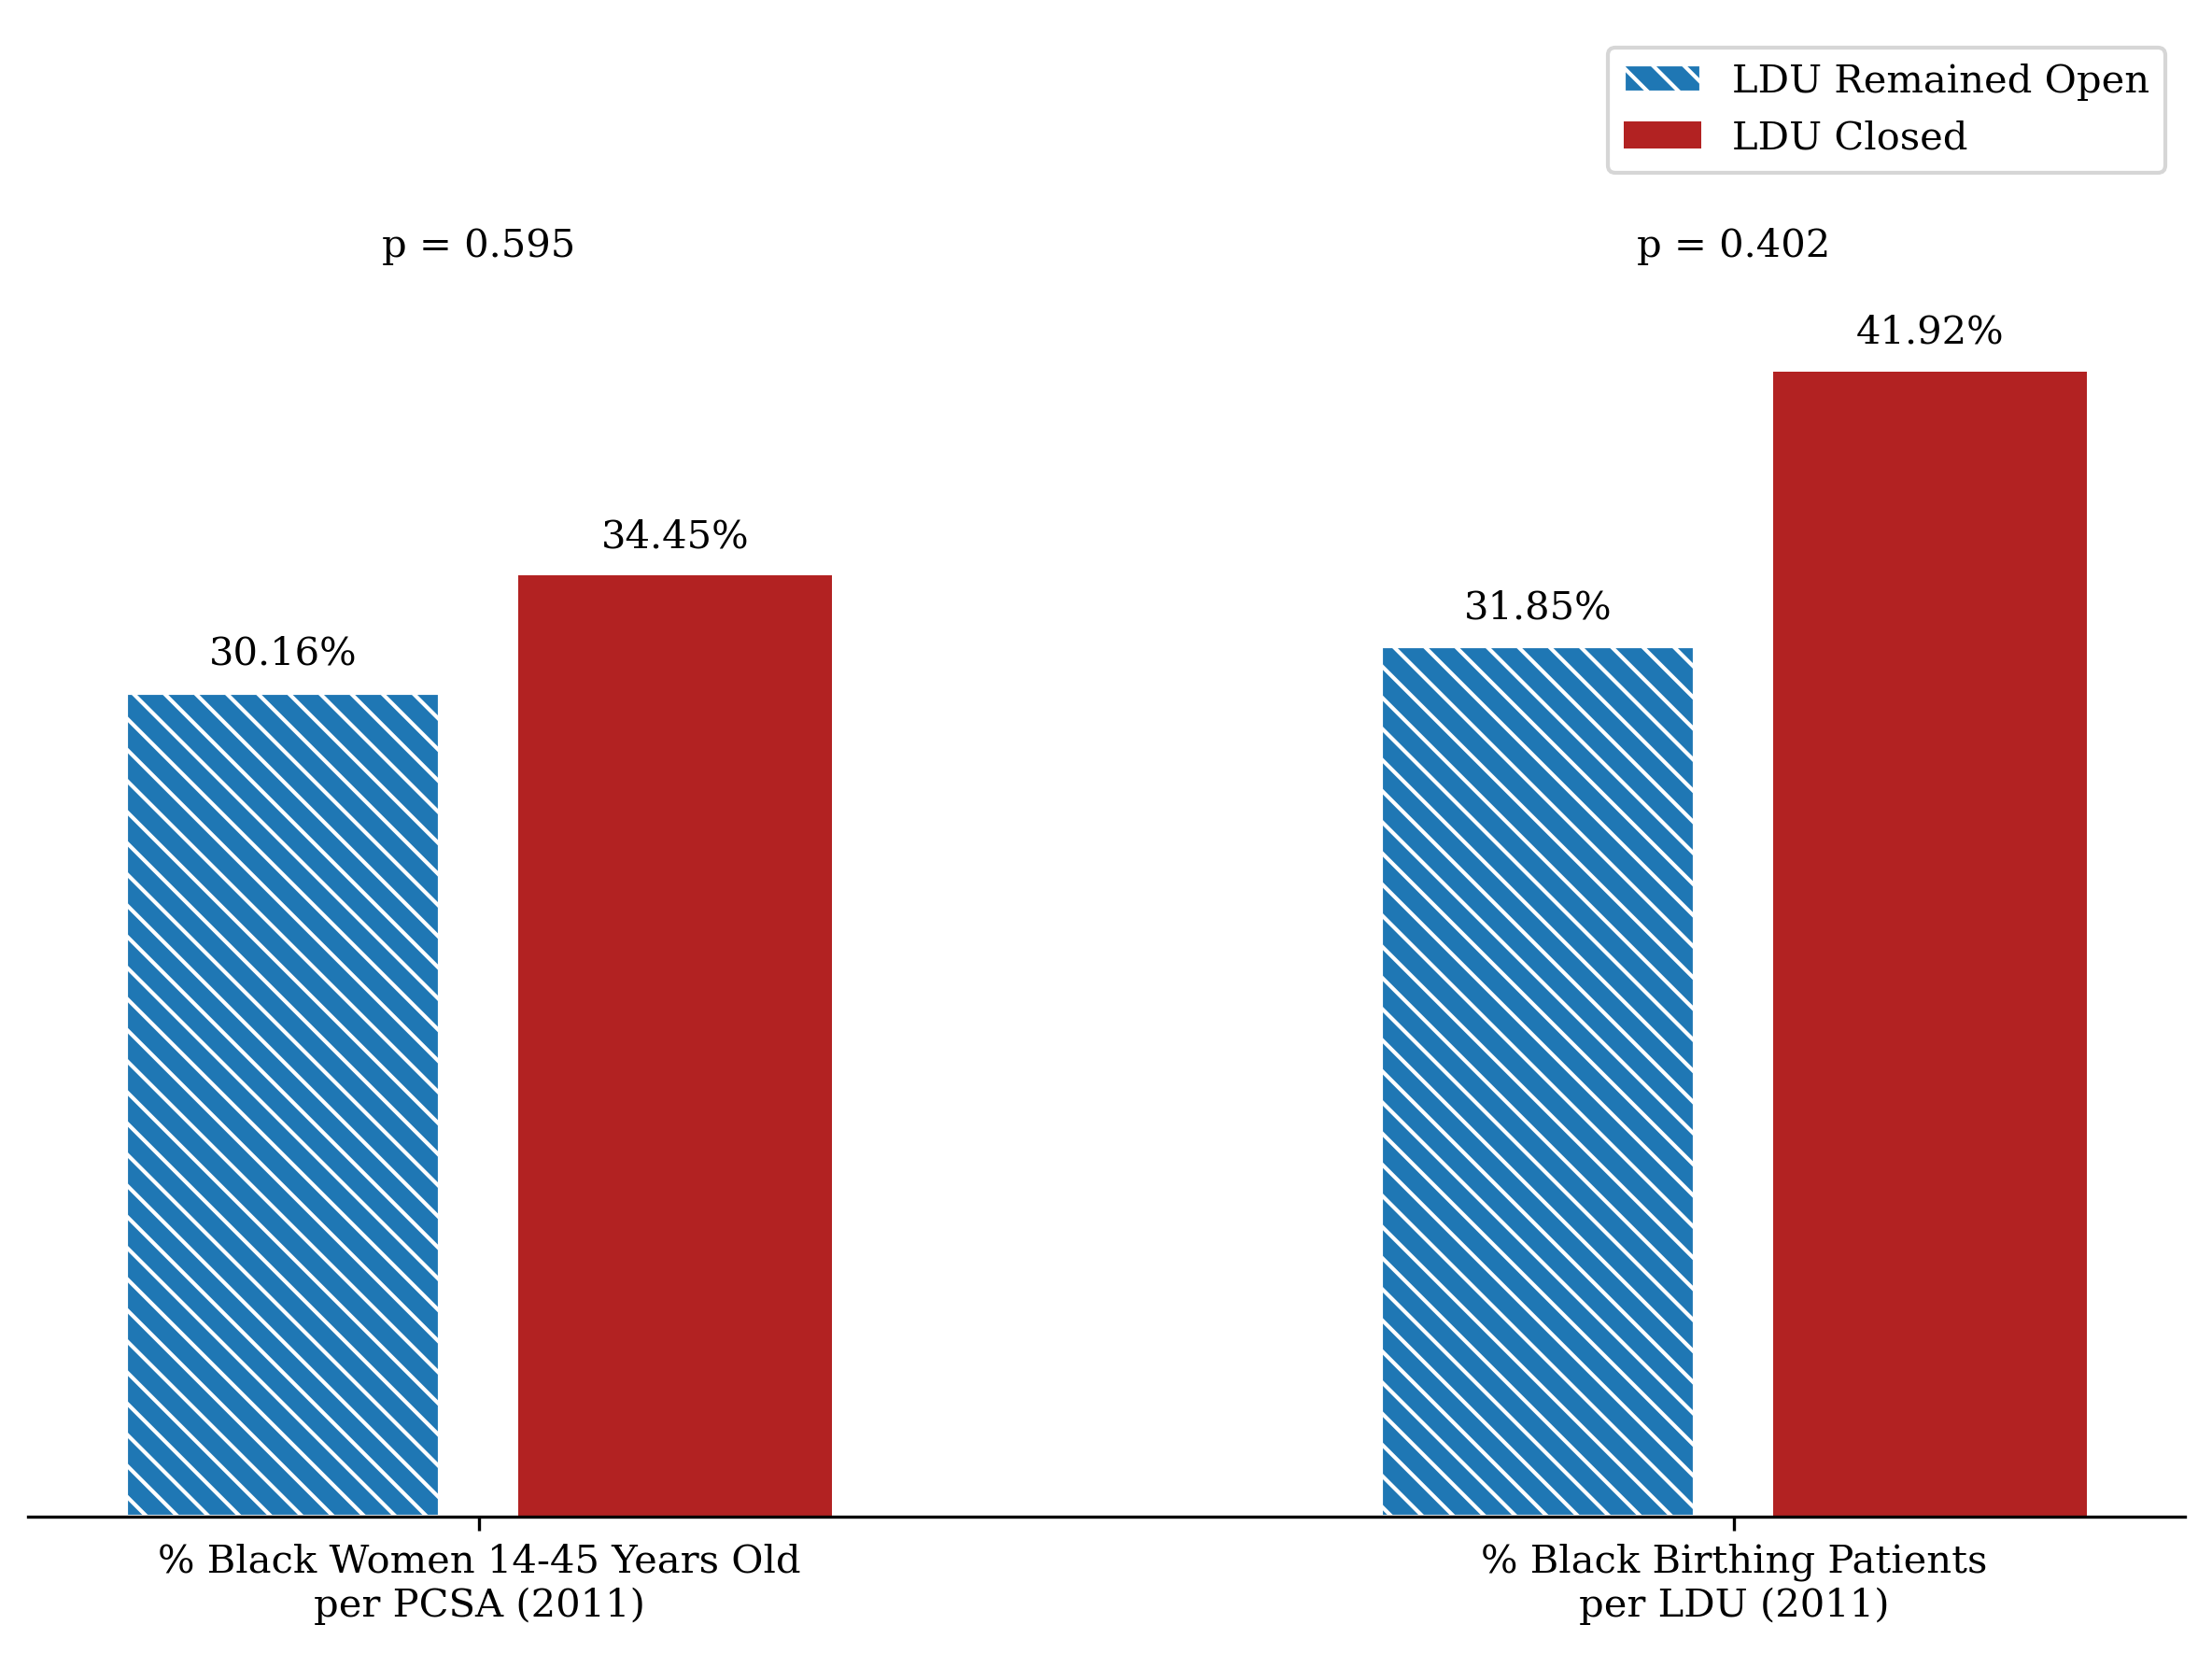

In [26]:
labels = ['% Black Women 14-45 Years Old\nper PCSA (2011)', \
          '% Black Birthing Patients\nper LDU (2011)']
openvals = [30.163, 31.851]
closedvals = [34.450, 41.918]
pvals = [0.595269252, 0.402128752]
plot_medians(labels, openvals, closedvals, pvals, fmt='{:.2f}%', anno='-fig1')

### Figure 2: Median Birth Volumes and Provider Loads

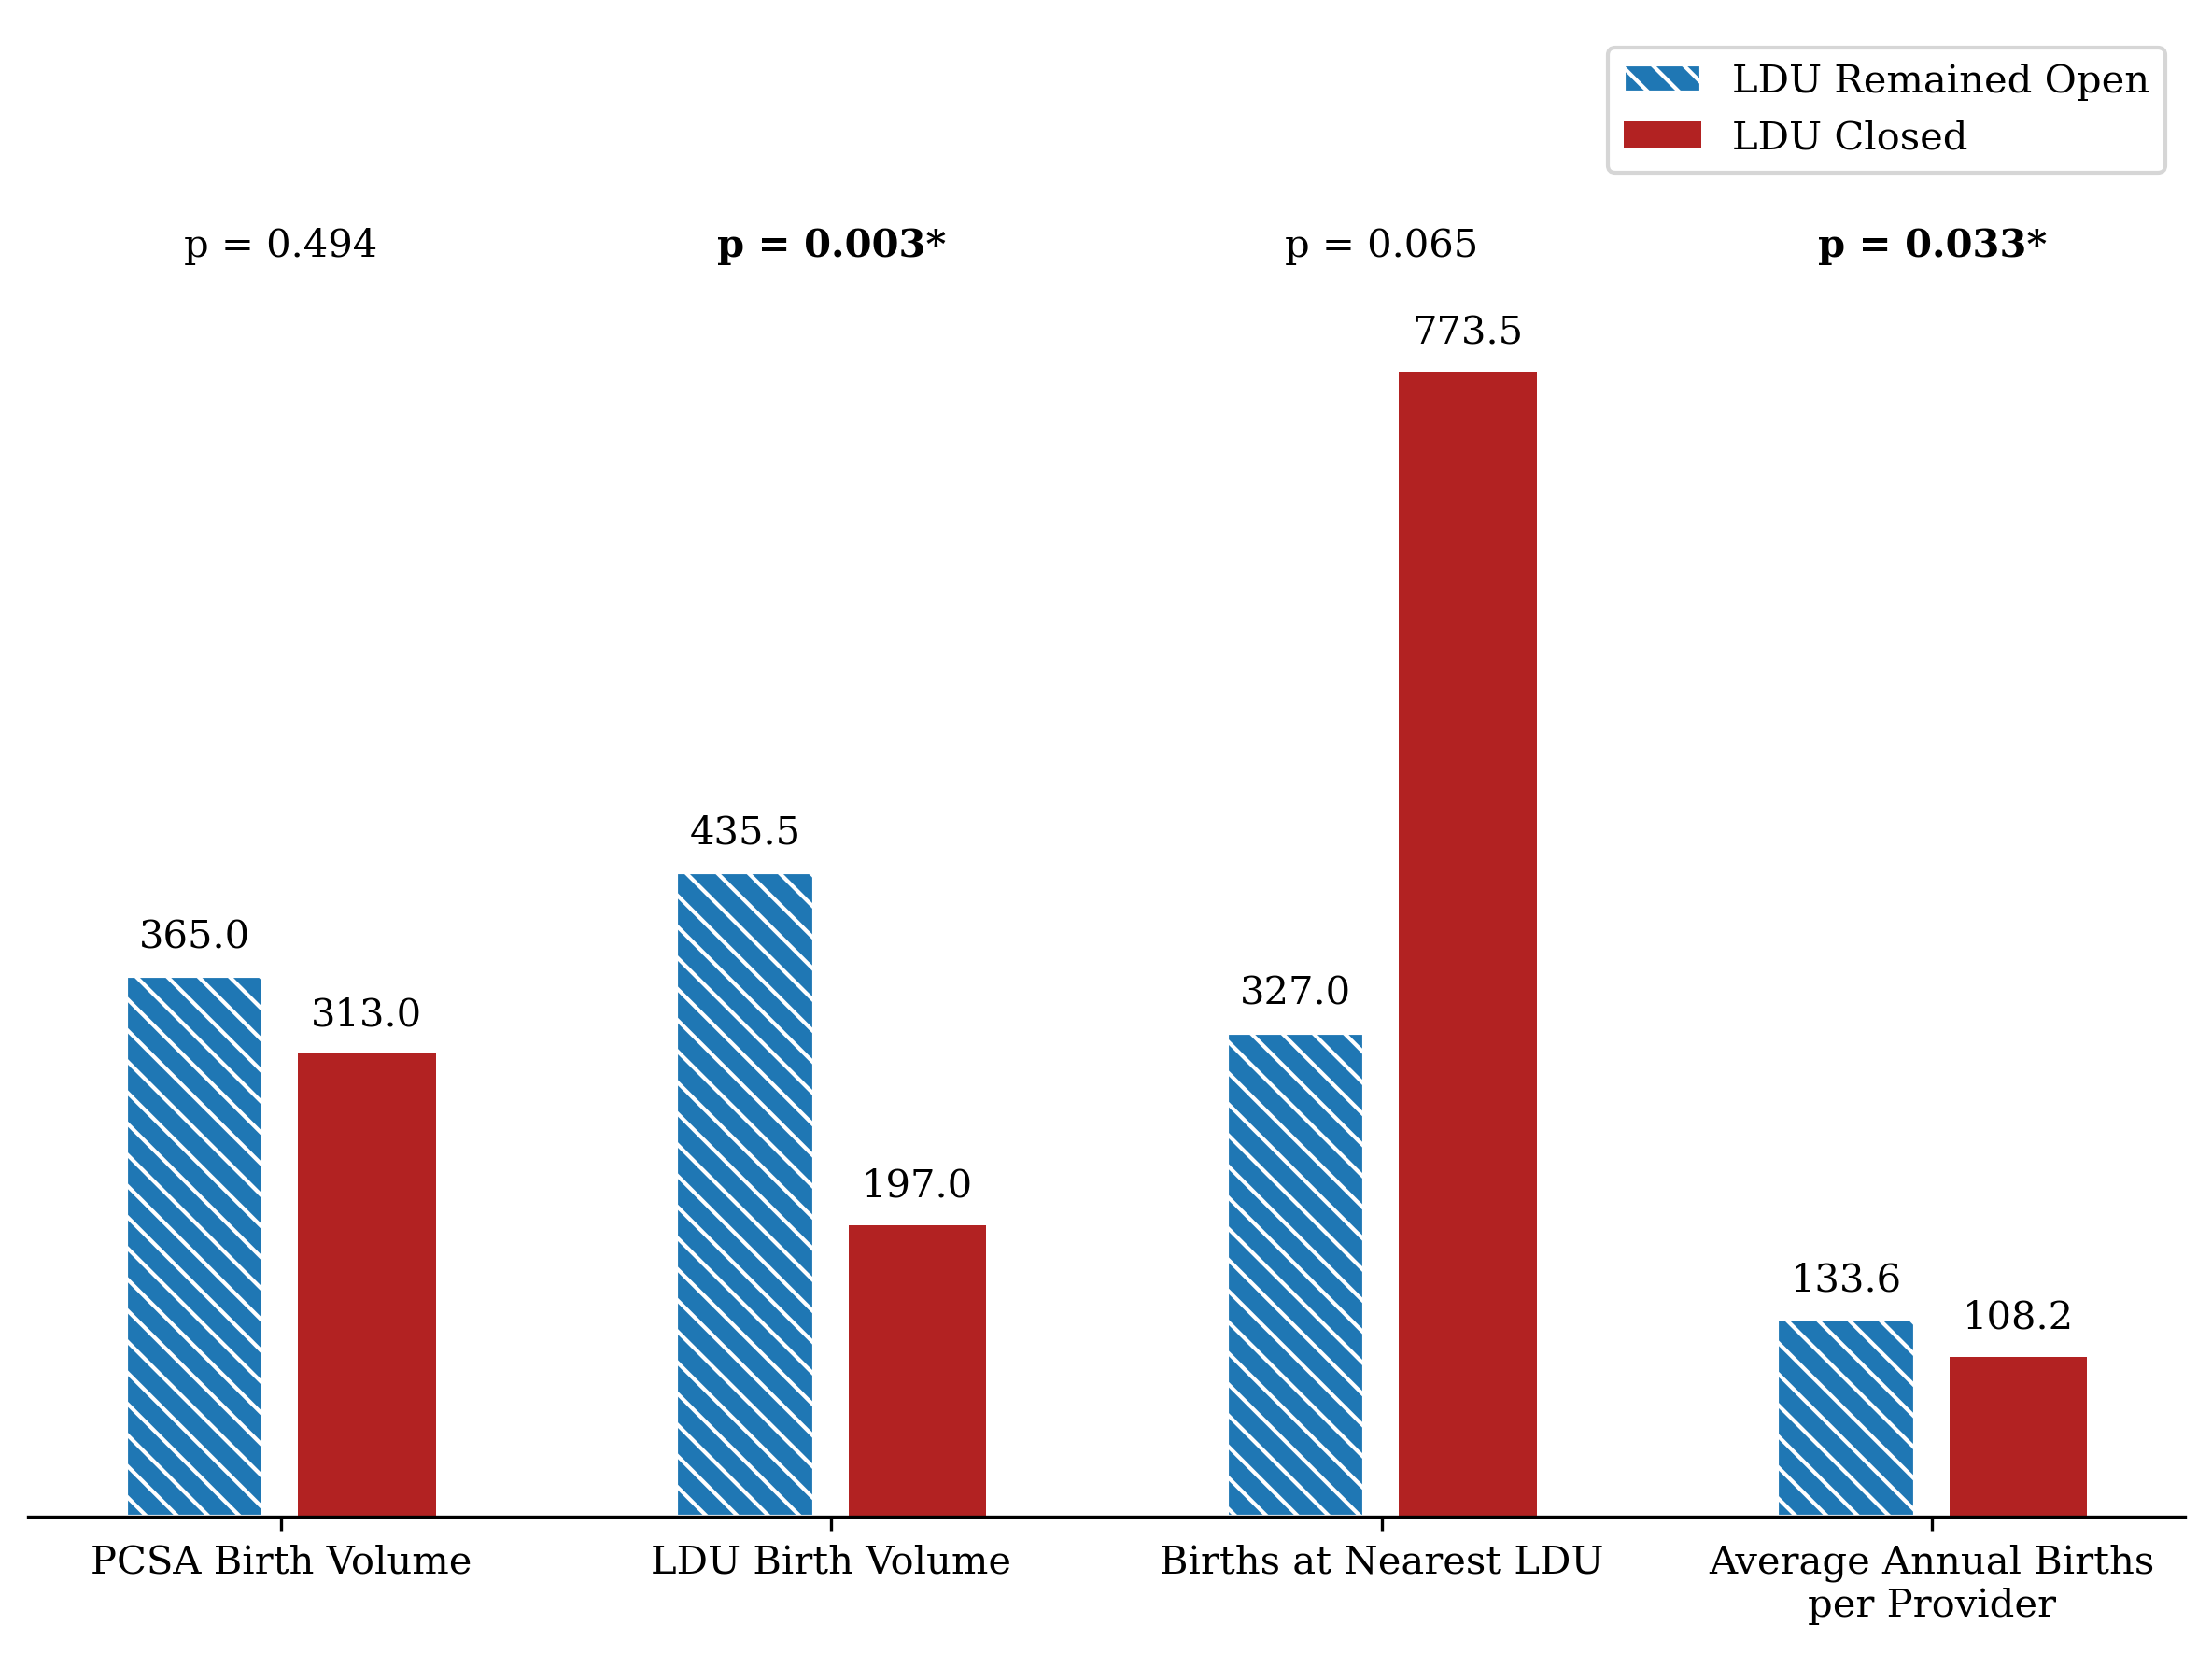

In [27]:
labels = ['PCSA Birth Volume', 'LDU Birth Volume', 'Births at Nearest LDU', \
          'Average Annual Births\nper Provider']
openvals = [365, 435.5, 327, 133.638]
closedvals = [313, 197, 773.5, 108.250]
pvals = [0.493941308, 0.002684519, 0.064681066, 0.033120290]
plot_medians(labels, openvals, closedvals, pvals, fmt='{:.1f}', anno='-fig2')